In [34]:
from googleapiclient.discovery import build
import pandas as pd
from IPython.display import JSON
from dateutil import parser
import isodate
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
api_key = 'xxxxxxx'

In [3]:
# Parameter to be used

channel_ids = ['UC73zqrs0Th_a9dFUivEmv2A',]
playlist_id = "UU73zqrs0Th_a9dFUivEmv2A"

api_service_name = "youtube"
api_version = "v3"

youtube = build(
    api_service_name, api_version, developerKey=api_key)

In [5]:
"""
All function:
    ------------------------
    return "channel info DataFrame", "all video Id" and "video info"

"""

def get_youtube_info(youtube,channel_ids):
    all_data = []

    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=",".join(channel_ids)
    )
    response = request.execute()

    for data in response['items']:
        info = {'title':data['snippet']['title'],
               'publishedAt':data['snippet']['publishedAt'],
                'uploadId':data['contentDetails']['relatedPlaylists']['uploads'],
                'viewCount':data['statistics']['viewCount'],
                'videoCount':data['statistics']['videoCount'],
                'subscriberCount': data['statistics']['subscriberCount']
               }
        all_data.append(info)

    return pd.DataFrame(all_data)

def get_video_ids(youtube,playlist_id):
    
    video_ids = []
    
    request = youtube.playlistItems().list(
    part="snippet,contentDetails",
    playlistId=playlist_id,
        maxResults = 50
    )
    response = request.execute()
    

    for data in response['items']:
        video_ids.append(data['contentDetails']['videoId'])
    
    nextPageToken = response.get('nextPageToken')
    
    while ('nextPageToken' in response):
        request = youtube.playlistItems().list(
            part="snippet,contentDetails",
            playlistId=playlist_id,
                maxResults = 50,
            pageToken = nextPageToken
        )
        response = request.execute()


        for data in response['items']:
            video_ids.append(data['contentDetails']['videoId'])
        nextPageToken = response.get('nextPageToken')

    return video_ids

def get_video_info(youtube,video_ids):
    
    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=",".join(video_ids[i:i+50])
        )
        response = request.execute()

        for video in response['items']:
            detail_to_get = {
                'snippet':['channelTitle','publishedAt','channelId','title','tags'],
                'contentDetails':['duration','caption'],
                'statistics':['viewCount','likeCount','commentCount']
            }

            video_info = {}
            video_info['videoId'] = video['id']
            for key in detail_to_get:
                for value in detail_to_get[key]:
                    try:
                        video_info[value]=video[key][value]
                    except:
                        video_info[value] = None
            all_video_info.append(video_info)
    
    return pd.DataFrame(all_video_info)

In [6]:
channel_info = get_youtube_info(youtube,channel_ids)
channel_info

,title,publishedAt,uploadId,viewCount,videoCount,subscriberCount
0,Cong TV,2008-02-13T13:04:58Z,UU73zqrs0Th_a9dFUivEmv2A,1561667374,515,11300000


In [8]:
video_ids = get_video_ids(youtube,playlist_id)
len(video_ids)

513

#### What would be the reason why there are 2 missing video in Cong TV Channel.

- As I explore why the 2 video are missing, because it's on the `search list` I'm pulling all video on search list then I will pull the missing video in playlist items, since it has a limit to request to api, everytime i'm pulling the data it's reaching the maximum request quota.

In [10]:
video_df = get_video_info(youtube,video_ids)
video_df

,videoId,channelTitle,publishedAt,channelId,title,tags,duration,caption,viewCount,likeCount,commentCount
0,jd0Irs0QfCU,Cong TV,2023-08-02T10:55:28Z,UC73zqrs0Th_a9dFUivEmv2A,CONGUDESU,"[CONG TV, JUNNIE BOY, JUNNIE DAD, BOSS KENG, T...",PT19M47S,false,2522717,122369,5912
1,Q3RxzmnWafs,Cong TV,2023-07-24T10:24:58Z,UC73zqrs0Th_a9dFUivEmv2A,YOKOTO,"[CONG TV, JUNNIE BOY, JUNNIE DAD, BOSS KENG, T...",PT22M49S,false,3315285,158181,9426
2,grsmKuOXnFg,Cong TV,2023-07-17T10:46:29Z,UC73zqrs0Th_a9dFUivEmv2A,NOSAKAI,"[CONG TV, JUNNIE BOY, JUNNIE DAD, BOSS KENG, T...",PT23M47S,false,3429370,167392,11840
3,QlcPVitKjOM,Cong TV,2023-07-12T12:50:10Z,UC73zqrs0Th_a9dFUivEmv2A,RAYDORBYE,"[CONG TV, JUNNIE BOY, JUNNIE DAD, BOSS KENG, T...",PT14M40S,false,2864057,133270,10001
4,ejqybynOOYI,Cong TV,2023-06-11T03:07:08Z,UC73zqrs0Th_a9dFUivEmv2A,OTOMOTO,"[CONG TV, JUNNIE BOY, JUNNIE DAD, BOSS KENG, T...",PT30M1S,false,4983835,170007,8431
...,...,...,...,...,...,...,...,...,...,...,...
508,Z_fsEijuZbY,Cong TV,2009-02-05T12:55:36Z,UC73zqrs0Th_a9dFUivEmv2A,Funny Stupid Random Dance Showdown,"[Dica, Saidali, Ivan, Vallejera, Cocon, Velasq...",PT4M19S,false,670751,33874,8506
509,w1YzptVytas,Cong TV,2009-02-02T12:30:27Z,UC73zqrs0Th_a9dFUivEmv2A,THIS WILL INSPIRE YOU TO TRAIN YOUR VERTICAL!,"[NBA, WNBA, Slam, Dunk, Most, Hyping, Song, Mu...",PT5M29S,false,1218022,50511,8446
510,z7o0ikHCmT0,Cong TV,2008-12-16T10:31:32Z,UC73zqrs0Th_a9dFUivEmv2A,Instant Transmission Technique,"[Sony, Vegas, Pro, Son, Goku, Instant, Transmi...",PT10S,false,308001,9226,816
511,Pr43Fc8Tr_Q,Cong TV,2008-12-04T09:58:19Z,UC73zqrs0Th_a9dFUivEmv2A,Cocon Blaine - Mind Geek (lol),"[cocon, velasquez, mindgeek, nigahiga, moymoyp...",PT4M22S,false,2100956,106419,None


### Questions to answer:
- what are the average views per video
- are likes and comments has a factor for views
- How long are usually the videos
- when are the day most frequent uploads
- What year did his channel viral

# Data Pre-processing

In [11]:
video_df.dtypes

videoId         object
channelTitle    object
publishedAt     object
channelId       object
title           object
tags            object
duration        object
caption         object
viewCount       object
likeCount       object
commentCount    object
dtype: object

In [12]:
# Check for null values
video_df.isna().any()

videoId         False
channelTitle    False
publishedAt     False
channelId       False
title           False
tags             True
duration        False
caption         False
viewCount       False
likeCount       False
commentCount     True
dtype: bool

In [13]:
"""
---------- Data transformation -----------

"""

# object to numeric
numeric_col = ['viewCount','likeCount','commentCount']
video_df[numeric_col] = video_df[numeric_col].apply(pd.to_numeric, axis=1)

# Column for day
video_df['publishedAt'] = video_df['publishedAt'].apply(lambda x: parser.parse(x))
video_df['publishedDayName'] = video_df['publishedAt'].apply(lambda x : x.strftime("%A"))

# Column for duration per second
video_df['durationSeconds'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSeconds'] = video_df['durationSeconds'].apply(lambda x: x / np.timedelta64(1, 's'))

# column for year
video_df['publishedYear'] = video_df['publishedAt'].apply(lambda x : x.strftime("%Y"))

In [20]:
video_df

,videoId,channelTitle,publishedAt,channelId,title,tags,duration,caption,viewCount,likeCount,commentCount,publishedDayName,durationSeconds
0,jd0Irs0QfCU,Cong TV,2023-08-02 10:55:28+00:00,UC73zqrs0Th_a9dFUivEmv2A,CONGUDESU,"[CONG TV, JUNNIE BOY, JUNNIE DAD, BOSS KENG, T...",PT19M47S,false,2522717.0,122369.0,5912.0,Wednesday,1187.0
1,Q3RxzmnWafs,Cong TV,2023-07-24 10:24:58+00:00,UC73zqrs0Th_a9dFUivEmv2A,YOKOTO,"[CONG TV, JUNNIE BOY, JUNNIE DAD, BOSS KENG, T...",PT22M49S,false,3315285.0,158181.0,9426.0,Monday,1369.0
2,grsmKuOXnFg,Cong TV,2023-07-17 10:46:29+00:00,UC73zqrs0Th_a9dFUivEmv2A,NOSAKAI,"[CONG TV, JUNNIE BOY, JUNNIE DAD, BOSS KENG, T...",PT23M47S,false,3429370.0,167392.0,11840.0,Monday,1427.0
3,QlcPVitKjOM,Cong TV,2023-07-12 12:50:10+00:00,UC73zqrs0Th_a9dFUivEmv2A,RAYDORBYE,"[CONG TV, JUNNIE BOY, JUNNIE DAD, BOSS KENG, T...",PT14M40S,false,2864057.0,133270.0,10001.0,Wednesday,880.0
4,ejqybynOOYI,Cong TV,2023-06-11 03:07:08+00:00,UC73zqrs0Th_a9dFUivEmv2A,OTOMOTO,"[CONG TV, JUNNIE BOY, JUNNIE DAD, BOSS KENG, T...",PT30M1S,false,4983835.0,170007.0,8431.0,Sunday,1801.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
508,Z_fsEijuZbY,Cong TV,2009-02-05 12:55:36+00:00,UC73zqrs0Th_a9dFUivEmv2A,Funny Stupid Random Dance Showdown,"[Dica, Saidali, Ivan, Vallejera, Cocon, Velasq...",PT4M19S,false,670751.0,33874.0,8506.0,Thursday,259.0
509,w1YzptVytas,Cong TV,2009-02-02 12:30:27+00:00,UC73zqrs0Th_a9dFUivEmv2A,THIS WILL INSPIRE YOU TO TRAIN YOUR VERTICAL!,"[NBA, WNBA, Slam, Dunk, Most, Hyping, Song, Mu...",PT5M29S,false,1218022.0,50511.0,8446.0,Monday,329.0
510,z7o0ikHCmT0,Cong TV,2008-12-16 10:31:32+00:00,UC73zqrs0Th_a9dFUivEmv2A,Instant Transmission Technique,"[Sony, Vegas, Pro, Son, Goku, Instant, Transmi...",PT10S,false,308001.0,9226.0,816.0,Tuesday,10.0
511,Pr43Fc8Tr_Q,Cong TV,2008-12-04 09:58:19+00:00,UC73zqrs0Th_a9dFUivEmv2A,Cocon Blaine - Mind Geek (lol),"[cocon, velasquez, mindgeek, nigahiga, moymoyp...",PT4M22S,false,2100956.0,106419.0,NaN,Thursday,262.0


## EDA

### Top 10 video

Text(0, 0.5, 'Views')

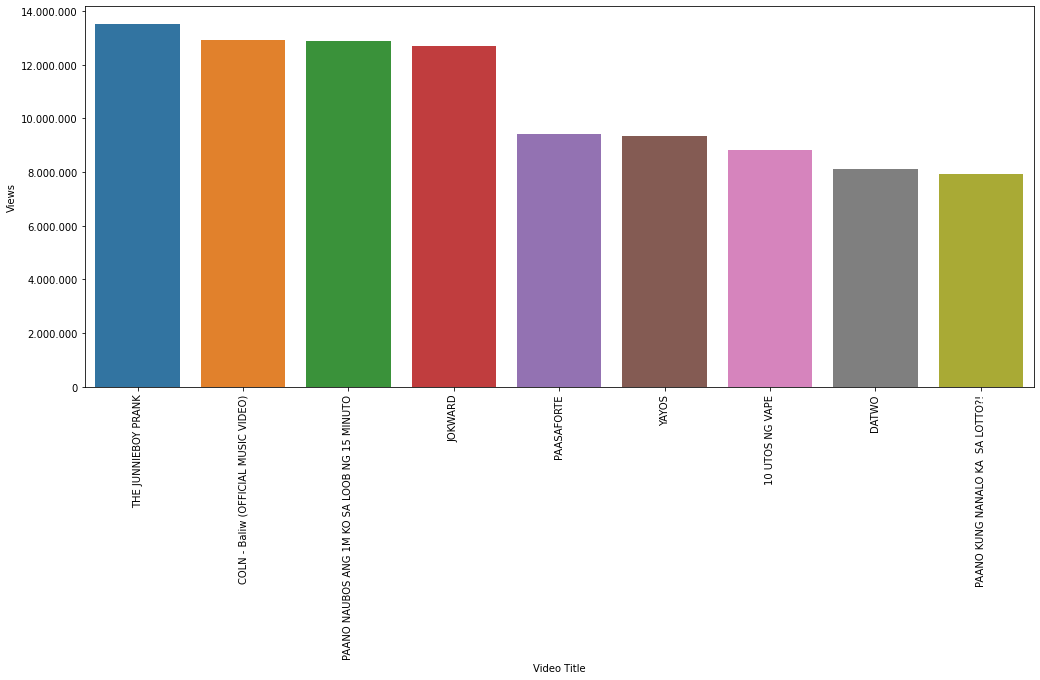

In [36]:
fig, ax = plt.subplots(figsize=(17,7))
sns.barplot(x='title', y='viewCount', data=video_df.sort_values('viewCount', ascending=False)[0:9])
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(
        lambda x, p: str.replace(format(int(x), ','), ',', '.')
    )
)
ax.set_xlabel("Video Title")
ax.set_ylabel("Views")

### Top 10 lowest views

Text(0, 0.5, 'Views')

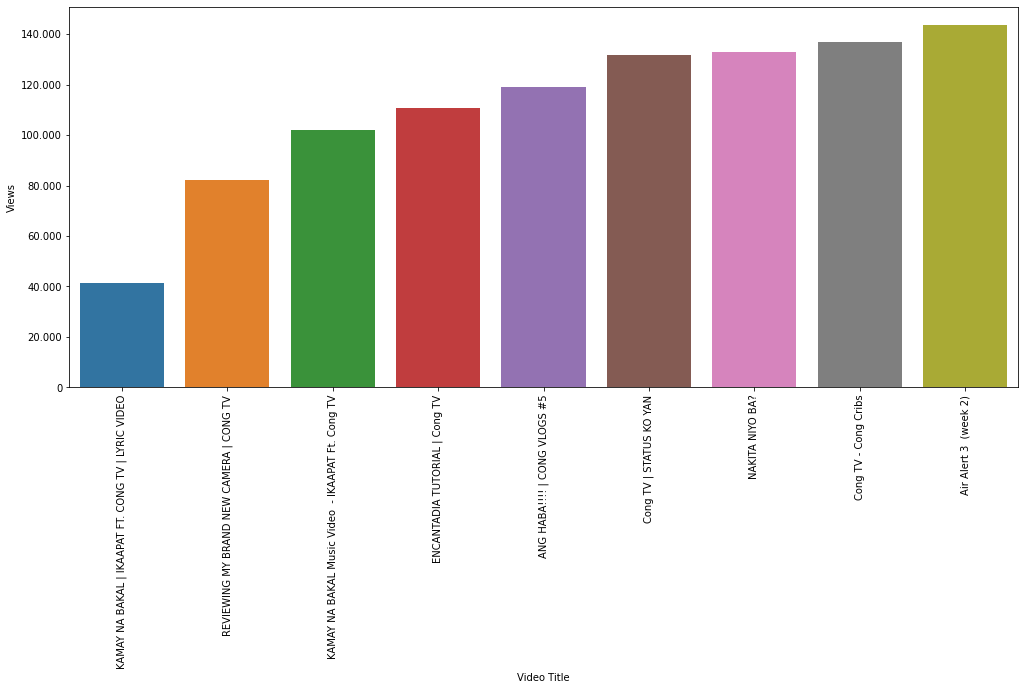

In [37]:
fig, ax = plt.subplots(figsize=(17,7))
sns.barplot(x='title', y='viewCount', data=video_df.sort_values('viewCount', ascending=True)[0:9])
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(
        lambda x, p: str.replace(format(int(x), ','), ',', '.')
    )
)
ax.set_xlabel("Video Title")
ax.set_ylabel("Views")

### View distribution

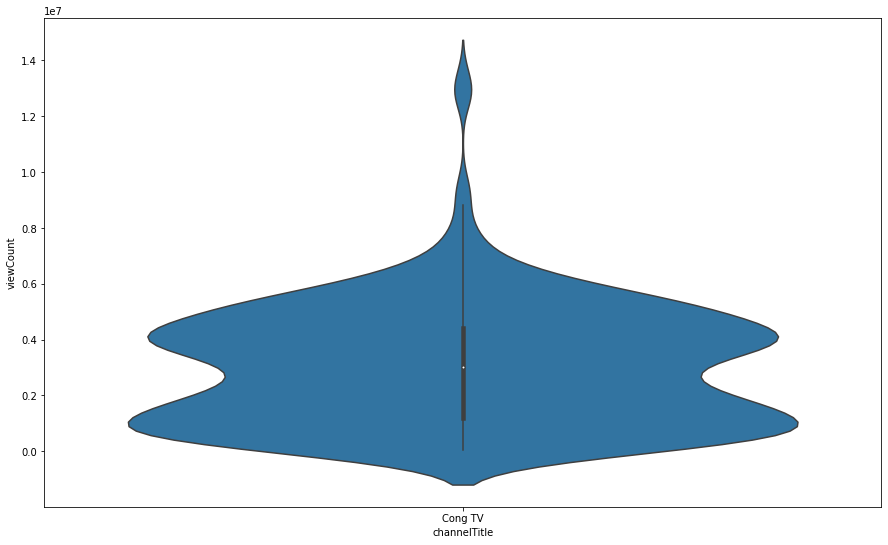

In [112]:
fig, ax = plt.subplots( figsize=(15,9))
ax = sns.violinplot(x=video_df['channelTitle'],y=video_df['viewCount'], ax=ax)

<AxesSubplot:xlabel='channelTitle', ylabel='viewCount'>

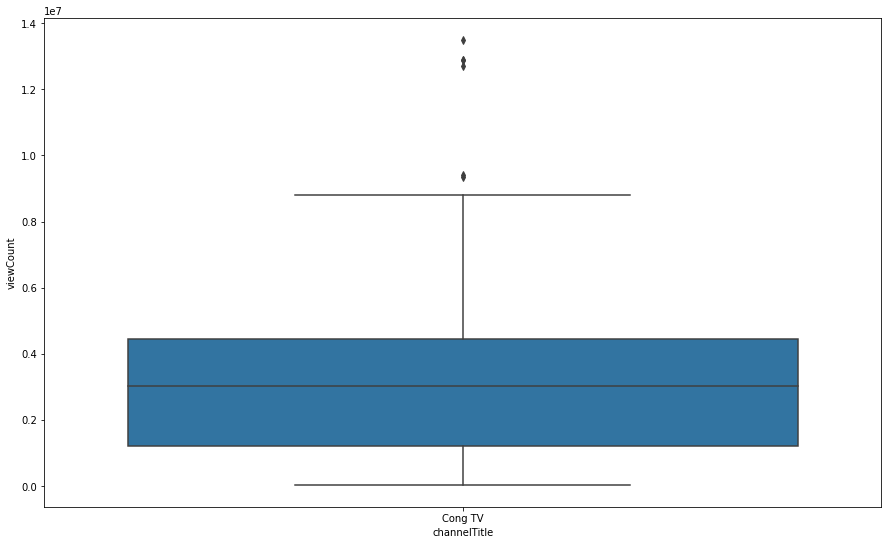

In [111]:
fig, ax = plt.subplots(figsize=(15,9))
sns.boxplot(x=video_df['channelTitle'],y=video_df['viewCount'], ax= ax)

### Are likes and comments has a factor for views

In [58]:
video_df.columns

Index(['videoId', 'channelTitle', 'publishedAt', 'channelId', 'title', 'tags',
       'duration', 'caption', 'viewCount', 'likeCount', 'commentCount',
       'publishedDayName', 'durationSeconds'],
      dtype='object')

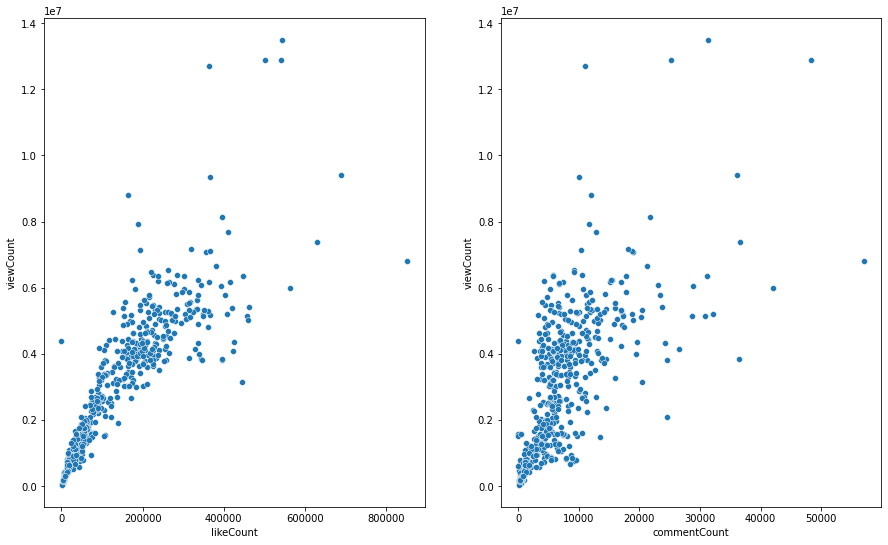

In [104]:
count_col = ['likeCount','commentCount']

fig, axes = plt.subplots(1,2, figsize=(15,9))

for i in range(len(count_col)):
    sns.scatterplot(data=video_df, y='viewCount', x=count_col[i], ax=axes[i])

### How long are usually the videos

<AxesSubplot:xlabel='durationSeconds', ylabel='Count'>

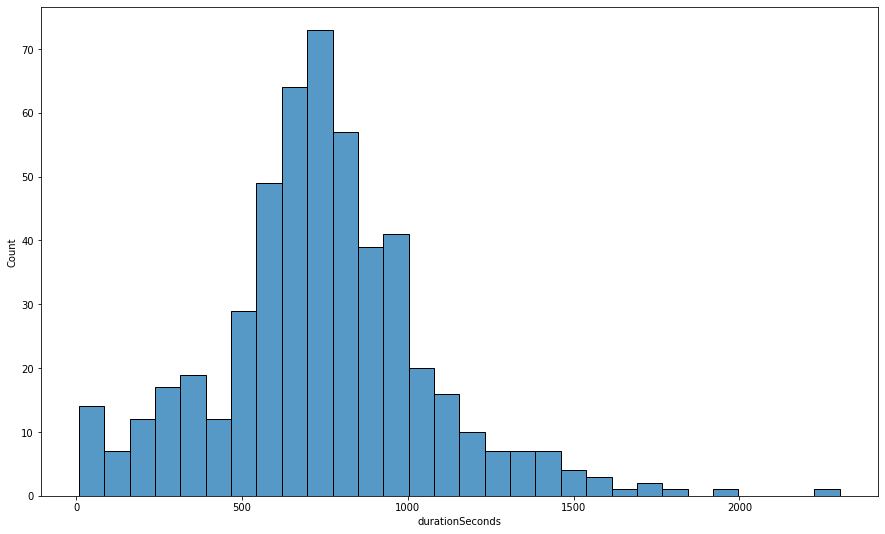

In [109]:
fig, ax = plt.subplots(figsize=(15,9))
sns.histplot(data = video_df, x='durationSeconds', bins=30, ax=ax)

### when are the day most frequent uploads

<AxesSubplot:xlabel='publishedDayName'>

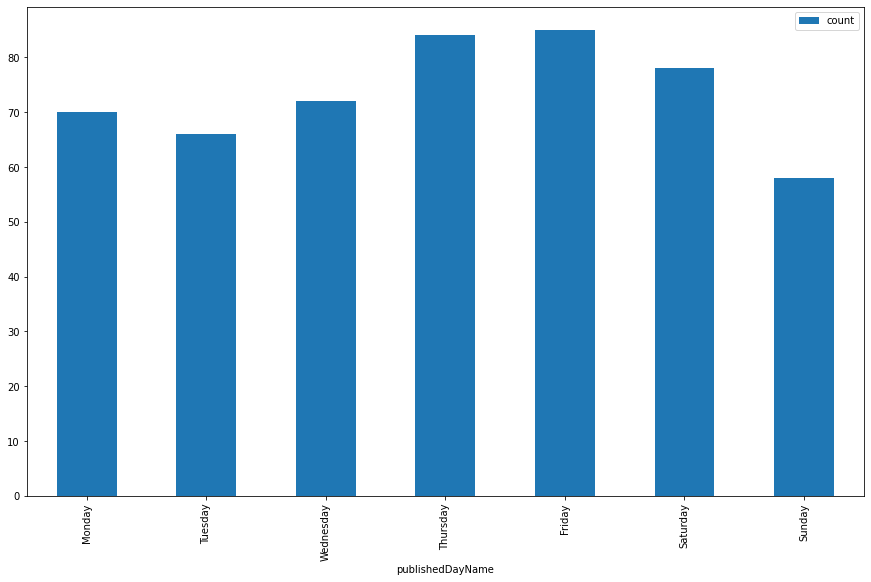

In [105]:
day_df = pd.DataFrame(video_df['publishedDayName'].value_counts())
day_of_week = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
day_df = day_df.reindex(day_of_week)
day_df.reset_index().plot.bar(x='publishedDayName',y='count', figsize=(15,9))

### What year has the most viewed

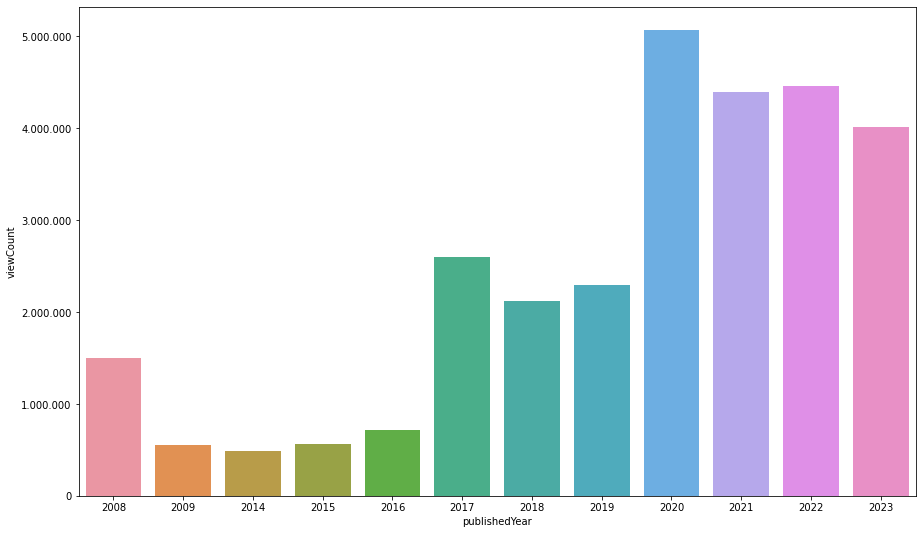

In [110]:
ave_per_year = pd.DataFrame(video_df.groupby(['publishedYear'])['viewCount'].mean().reset_index())
fig, ax = plt.subplots(figsize=(15,9))
sns.barplot(data=ave_per_year, x='publishedYear', y='viewCount', ax=ax)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(
        lambda x, p: str.replace(format(int(x), ','), ',', '.')
    )
)